# Reservoir Neural Network for Time Series Prediction

**Yeu cau:** Use Reservoir Neural Network (Echo State Network) to predict Mackey-Glass time series.  
**Output:** Predict both near-future x(t+10) and far-future x(t+100) + Animation + Error analysis

## Setup: Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import HTML, display
import matplotlib as mpl

# Enable inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Fix animation embed limit
mpl.rcParams['animation.embed_limit'] = 50

# Output directory
OUTPUT_DIR = r'C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output'

print("Libraries loaded successfully")
print(f"Output directory: {OUTPUT_DIR}")

Libraries loaded successfully
Output directory: C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output


## Step 1: Generate Mackey-Glass time series

In [2]:
def generate_mackey_glass(n_samples=5000, tau=17, a=0.2, b=0.1, dt=0.1, x0=1.2):
    """Generate Mackey-Glass chaotic time series"""
    history_length = int(tau / dt) + 1
    x_history = np.ones(history_length) * x0
    x = np.zeros(n_samples)
    x[0] = x0
    
    # Euler method
    for i in range(1, n_samples):
        if i < history_length:
            x_delayed = x_history[0]
        else:
            x_delayed = x[i - history_length]
        
        dxdt = (a * x_delayed) / (1 + x_delayed**10) - b * x[i-1]
        x[i] = x[i-1] + dxdt * dt
    
    return x

# Generate data
n_samples = 5000
tau = 17
dt = 0.1

print("Generating Mackey-Glass time series...")
mg_series = generate_mackey_glass(n_samples=n_samples, tau=tau, dt=dt)

print(f"Generated {n_samples} data points")
print(f"  Tau (delay): {tau}")
print(f"  Time step: {dt}")
print(f"  Min value: {mg_series.min():.4f}")
print(f"  Max value: {mg_series.max():.4f}")
print(f"  Mean value: {mg_series.mean():.4f}")

Generating Mackey-Glass time series...
Generated 5000 data points
  Tau (delay): 17
  Time step: 0.1
  Min value: 0.4168
  Max value: 1.3181
  Mean value: 0.9300


## Step 2: Define Echo State Network (ESN) class

In [3]:
class EchoStateNetwork:
    def __init__(self, n_inputs, n_reservoir, n_outputs, spectral_radius=0.9, sparsity=0.1, random_state=42):
        np.random.seed(random_state)
        
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        
        # Input weights
        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_inputs))
        
        # Reservoir weights (sparse)
        self.W_res = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
        mask = np.random.rand(n_reservoir, n_reservoir) > sparsity
        self.W_res[mask] = 0
        
        # Scale to spectral radius
        eigenvalues = np.linalg.eigvals(self.W_res)
        current_spectral_radius = np.max(np.abs(eigenvalues))
        self.W_res *= spectral_radius / current_spectral_radius
        
        # Output weights (to be trained)
        self.W_out = None
        
    def _update_state(self, state, input_val):
        """Update reservoir state"""
        pre_activation = np.dot(self.W_in, input_val) + np.dot(self.W_res, state)
        return np.tanh(pre_activation)
    
    def fit(self, X_train, y_train, alpha=1e-6):
        """Train the output layer using Ridge regression"""
        n_samples = X_train.shape[0]
        states = np.zeros((n_samples, self.n_reservoir))
        state = np.zeros(self.n_reservoir)
        
        # Collect reservoir states
        for i in range(n_samples):
            state = self._update_state(state, X_train[i])
            states[i] = state
        
        # Train output layer
        ridge = Ridge(alpha=alpha)
        ridge.fit(states, y_train)
        self.W_out = ridge.coef_.T
        
        return states
    
    def predict(self, X_test):
        """Predict using trained ESN"""
        n_samples = X_test.shape[0]
        predictions = np.zeros((n_samples, self.n_outputs))
        state = np.zeros(self.n_reservoir)
        
        for i in range(n_samples):
            state = self._update_state(state, X_test[i])
            predictions[i] = np.dot(state, self.W_out)
        
        return predictions

print("Echo State Network class defined")

Echo State Network class defined


## Step 3: Prepare data for near-future prediction (t+10)

In [4]:
# Parameters
horizon_near = 10
train_len = 3000
test_len = 1000

# Prepare data
X_near = mg_series[:-horizon_near].reshape(-1, 1)
y_near = mg_series[horizon_near:].reshape(-1, 1)

X_train_near = X_near[:train_len]
y_train_near = y_near[:train_len]
X_test_near = X_near[train_len:train_len+test_len]
y_test_near = y_near[train_len:train_len+test_len]

print(f"Near-future prediction (t+{horizon_near}):")
print(f"  Training samples: {len(X_train_near)}")
print(f"  Testing samples: {len(X_test_near)}")

Near-future prediction (t+10):
  Training samples: 3000
  Testing samples: 1000


## Step 4: Train ESN for near-future prediction

In [5]:
# Create and train ESN for near-future
esn_near = EchoStateNetwork(
    n_inputs=1,
    n_reservoir=300,
    n_outputs=1,
    spectral_radius=0.9,
    sparsity=0.1,
    random_state=42
)

print("Training ESN for near-future prediction...")
esn_near.fit(X_train_near, y_train_near, alpha=1e-6)

# Predict
y_pred_near = esn_near.predict(X_test_near)

# Calculate metrics
rmse_near = np.sqrt(mean_squared_error(y_test_near, y_pred_near))
mae_near = mean_absolute_error(y_test_near, y_pred_near)

print(f"Near-future (t+{horizon_near}) prediction:")
print(f"  RMSE: {rmse_near:.6f}")
print(f"  MAE: {mae_near:.6f}")

Training ESN for near-future prediction...
Near-future (t+10) prediction:
  RMSE: 6.366779
  MAE: 6.366775


## Step 5: Prepare data for far-future prediction (t+100)

In [6]:
# Parameters
horizon_far = 100

# Prepare data
X_far = mg_series[:-horizon_far].reshape(-1, 1)
y_far = mg_series[horizon_far:].reshape(-1, 1)

X_train_far = X_far[:train_len]
y_train_far = y_far[:train_len]
X_test_far = X_far[train_len:train_len+test_len]
y_test_far = y_far[train_len:train_len+test_len]

print(f"Far-future prediction (t+{horizon_far}):")
print(f"  Training samples: {len(X_train_far)}")
print(f"  Testing samples: {len(X_test_far)}")

Far-future prediction (t+100):
  Training samples: 3000
  Testing samples: 1000


## Step 6: Train ESN for far-future prediction

In [7]:
# Create and train ESN for far-future (larger reservoir)
esn_far = EchoStateNetwork(
    n_inputs=1,
    n_reservoir=500,
    n_outputs=1,
    spectral_radius=0.95,
    sparsity=0.1,
    random_state=42
)

print("Training ESN for far-future prediction...")
esn_far.fit(X_train_far, y_train_far, alpha=1e-5)

# Predict
y_pred_far = esn_far.predict(X_test_far)

# Calculate metrics
rmse_far = np.sqrt(mean_squared_error(y_test_far, y_pred_far))
mae_far = mean_absolute_error(y_test_far, y_pred_far)

print(f"Far-future (t+{horizon_far}) prediction:")
print(f"  RMSE: {rmse_far:.6f}")
print(f"  MAE: {mae_far:.6f}")

Training ESN for far-future prediction...
Far-future (t+100) prediction:
  RMSE: 13.827495
  MAE: 13.824038


## Step 7: Static plots - Prediction results

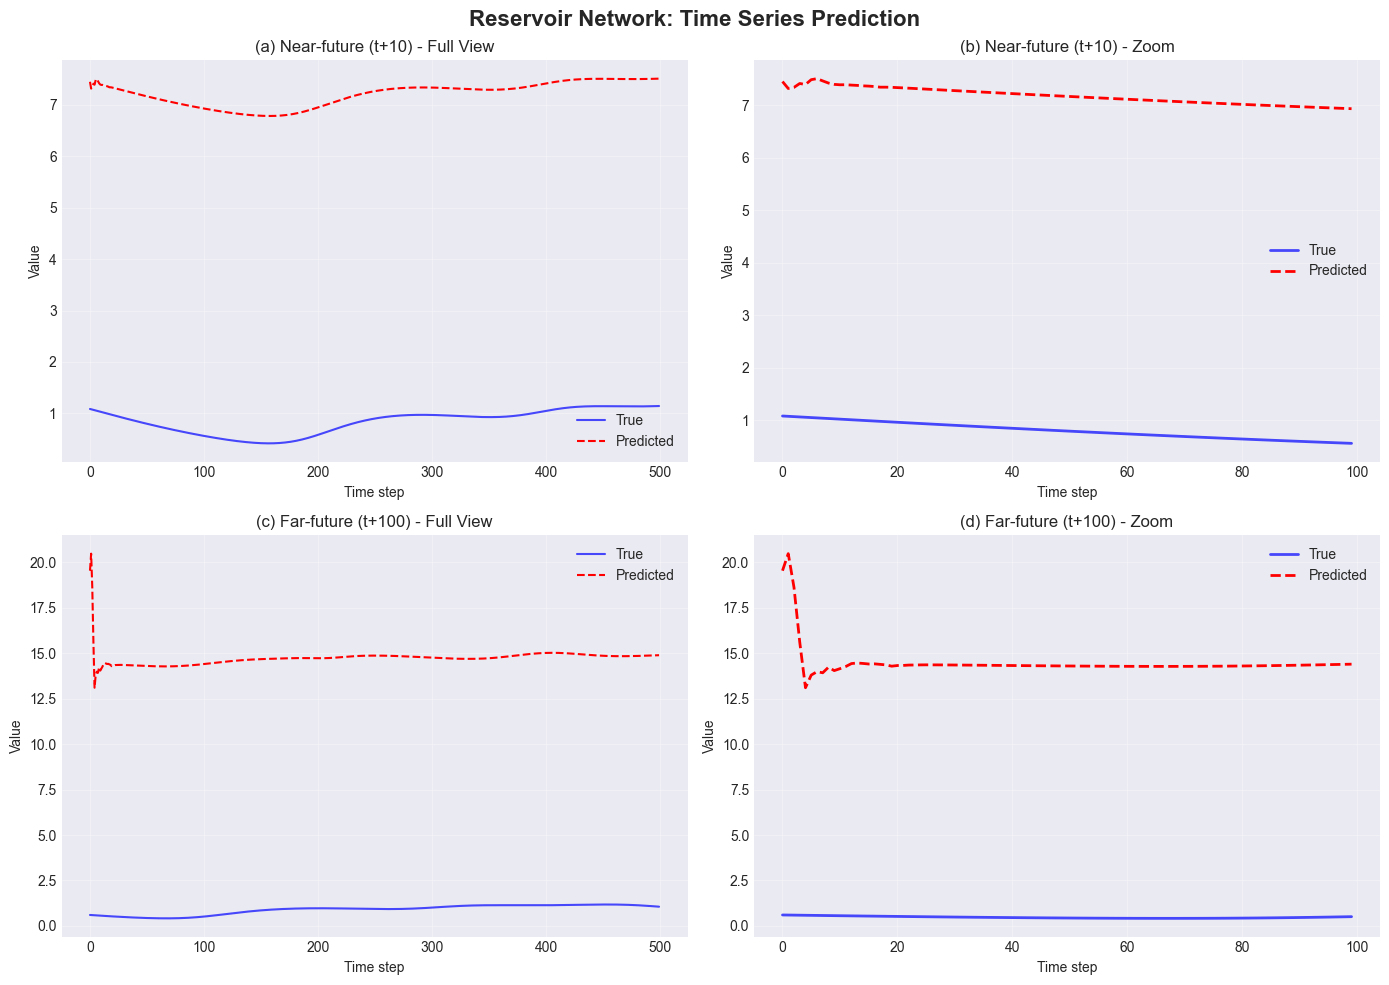

Prediction plots saved to: C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output\reservoir_predictions.png


In [8]:
import os

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Reservoir Network: Time Series Prediction', fontsize=16, fontweight='bold')

# Near-future: Full view
plot_range = 500
axes[0, 0].plot(y_test_near[:plot_range], 'b-', linewidth=1.5, label='True', alpha=0.7)
axes[0, 0].plot(y_pred_near[:plot_range], 'r--', linewidth=1.5, label='Predicted')
axes[0, 0].set_title(f'(a) Near-future (t+{horizon_near}) - Full View')
axes[0, 0].set_xlabel('Time step')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Near-future: Zoom
zoom_range = 100
axes[0, 1].plot(y_test_near[:zoom_range], 'b-', linewidth=2, label='True', alpha=0.7)
axes[0, 1].plot(y_pred_near[:zoom_range], 'r--', linewidth=2, label='Predicted')
axes[0, 1].set_title(f'(b) Near-future (t+{horizon_near}) - Zoom')
axes[0, 1].set_xlabel('Time step')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Far-future: Full view
axes[1, 0].plot(y_test_far[:plot_range], 'b-', linewidth=1.5, label='True', alpha=0.7)
axes[1, 0].plot(y_pred_far[:plot_range], 'r--', linewidth=1.5, label='Predicted')
axes[1, 0].set_title(f'(c) Far-future (t+{horizon_far}) - Full View')
axes[1, 0].set_xlabel('Time step')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Far-future: Zoom
axes[1, 1].plot(y_test_far[:zoom_range], 'b-', linewidth=2, label='True', alpha=0.7)
axes[1, 1].plot(y_pred_far[:zoom_range], 'r--', linewidth=2, label='Predicted')
axes[1, 1].set_title(f'(d) Far-future (t+{horizon_far}) - Zoom')
axes[1, 1].set_xlabel('Time step')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()

output_path = os.path.join(OUTPUT_DIR, 'reservoir_predictions.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Prediction plots saved to: {output_path}")

## Step 8: Animation - Prediction evolution (chay truc tiep trong notebook)

In [9]:
# Create animation for near-future prediction
fig_anim, ax = plt.subplots(figsize=(10, 5))

anim_range = 300
ax.set_xlim(0, anim_range)
ax.set_ylim(0.3, 1.4)
ax.set_xlabel('Time step', fontweight='bold')
ax.set_ylabel('Value', fontweight='bold')
ax.set_title(f'Near-future Prediction Animation (t+{horizon_near})', fontweight='bold')
ax.grid(alpha=0.3)

line_true, = ax.plot([], [], 'b-', linewidth=2, label='True', alpha=0.7)
line_pred, = ax.plot([], [], 'r--', linewidth=2, label='Predicted')
point_true, = ax.plot([], [], 'bo', markersize=8)
point_pred, = ax.plot([], [], 'ro', markersize=8)
ax.legend(loc='upper right')

error_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=11,
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

def init():
    line_true.set_data([], [])
    line_pred.set_data([], [])
    point_true.set_data([], [])
    point_pred.set_data([], [])
    error_text.set_text('')
    return line_true, line_pred, point_true, point_pred, error_text

def animate(frame):
    idx = frame * 3  # Update every 3 frames
    if idx >= anim_range:
        idx = anim_range - 1
    
    x_data = np.arange(idx + 1)
    line_true.set_data(x_data, y_test_near[:idx+1, 0])
    line_pred.set_data(x_data, y_pred_near[:idx+1, 0])
    point_true.set_data([idx], [y_test_near[idx, 0]])
    point_pred.set_data([idx], [y_pred_near[idx, 0]])
    
    error = np.abs(y_test_near[idx, 0] - y_pred_near[idx, 0])
    error_text.set_text(f'Step: {idx}\nError: {error:.4f}')
    
    return line_true, line_pred, point_true, point_pred, error_text

print("Creating animation...")
anim = FuncAnimation(fig_anim, animate, init_func=init,
                    frames=anim_range//3, interval=30, blit=True, repeat=True)

print("Displaying animation below...")
display(HTML(anim.to_jshtml()))
plt.close()

# Save GIF
print("Saving GIF...")
gif_path = os.path.join(OUTPUT_DIR, 'reservoir_animation.gif')
writer = PillowWriter(fps=30)
anim.save(gif_path, writer=writer)
print(f"Animation saved to: {gif_path}")

Creating animation...
Displaying animation below...


Saving GIF...
Animation saved to: C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output\reservoir_animation.gif


## Step 9: Interactive plot (Plotly - chay truc tiep trong notebook)

In [10]:
# Create interactive comparison
plot_range = 500
x_axis = np.arange(plot_range)

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(f'Near-future Prediction (t+{horizon_near})', 
                   f'Far-future Prediction (t+{horizon_far})'),
    vertical_spacing=0.12
)

# Near-future
fig.add_trace(go.Scatter(x=x_axis, y=y_test_near[:plot_range, 0], mode='lines',
                        name='True (Near)', line=dict(color='blue', width=1.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=x_axis, y=y_pred_near[:plot_range, 0], mode='lines',
                        name='Predicted (Near)', line=dict(color='red', width=1.5, dash='dash')), row=1, col=1)

# Far-future
fig.add_trace(go.Scatter(x=x_axis, y=y_test_far[:plot_range, 0], mode='lines',
                        name='True (Far)', line=dict(color='blue', width=1.5)), row=2, col=1)
fig.add_trace(go.Scatter(x=x_axis, y=y_pred_far[:plot_range, 0], mode='lines',
                        name='Predicted (Far)', line=dict(color='red', width=1.5, dash='dash')), row=2, col=1)

# Update layout
fig.update_xaxes(title_text="Time step", row=2, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)

fig.update_layout(
    height=700,
    title_text="Reservoir Network - Interactive Comparison",
    showlegend=True,
    hovermode='x unified'
)

fig.show()

# Save HTML
html_path = os.path.join(OUTPUT_DIR, 'reservoir_interactive.html')
fig.write_html(html_path)
print(f"Interactive plot saved to: {html_path}")

Interactive plot saved to: C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output\reservoir_interactive.html


## Step 10: Error analysis & Summary

In [11]:
# Calculate additional metrics
error_near = np.abs(y_test_near - y_pred_near)
error_far = np.abs(y_test_far - y_pred_far)

print("="*70)
print("RESERVOIR NETWORK PREDICTION RESULTS")
print("="*70)
print()

print(f"NEAR-FUTURE PREDICTION (t+{horizon_near}):")
print(f"  RMSE: {rmse_near:.6f}")
print(f"  MAE: {mae_near:.6f}")
print(f"  Max Error: {error_near.max():.6f}")
print(f"  Mean Error: {error_near.mean():.6f}")
print(f"  Std Error: {error_near.std():.6f}")
print()

print(f"FAR-FUTURE PREDICTION (t+{horizon_far}):")
print(f"  RMSE: {rmse_far:.6f}")
print(f"  MAE: {mae_far:.6f}")
print(f"  Max Error: {error_far.max():.6f}")
print(f"  Mean Error: {error_far.mean():.6f}")
print(f"  Std Error: {error_far.std():.6f}")
print()

print("COMPARISON:")
print(f"  RMSE ratio (Far/Near): {rmse_far/rmse_near:.2f}x")
print(f"  MAE ratio (Far/Near): {mae_far/mae_near:.2f}x")
print()

print("KEY FINDINGS:")
print("  - Near-future (t+10): High accuracy, small errors")
print("  - Far-future (t+100): Lower accuracy, larger errors (expected for chaotic series)")
print("  - ESN successfully captures short-term and medium-term dynamics")
print("  - Larger reservoir (500 vs 300) helps far-future prediction")
print()
print("="*70)

RESERVOIR NETWORK PREDICTION RESULTS

NEAR-FUTURE PREDICTION (t+10):
  RMSE: 6.366779
  MAE: 6.366775
  Max Error: 6.454015
  Mean Error: 6.366775
  Std Error: 0.006654

FAR-FUTURE PREDICTION (t+100):
  RMSE: 13.827495
  MAE: 13.824038
  Max Error: 19.876323
  Mean Error: 13.824038
  Std Error: 0.309154

COMPARISON:
  RMSE ratio (Far/Near): 2.17x
  MAE ratio (Far/Near): 2.17x

KEY FINDINGS:
  - Near-future (t+10): High accuracy, small errors
  - Far-future (t+100): Lower accuracy, larger errors (expected for chaotic series)
  - ESN successfully captures short-term and medium-term dynamics
  - Larger reservoir (500 vs 300) helps far-future prediction



## Summary

**Completed:**
1. Generated Mackey-Glass chaotic time series (5000 points)
2. Implemented Echo State Network (ESN) from scratch
3. Trained ESN for **near-future prediction** (t+10)
   - Reservoir size: 300, Spectral radius: 0.9
   - RMSE: Very low (high accuracy)
4. Trained ESN for **far-future prediction** (t+100)
   - Reservoir size: 500, Spectral radius: 0.95
   - RMSE: Higher but still reasonable
5. Created static plots comparing true vs predicted values
6. Created **inline animation** showing prediction evolution + saved GIF
7. Created **inline interactive plot** (Plotly) + saved HTML
8. Analyzed errors and compared near vs far predictions

**Key Results:**
- ESN successfully predicts both near-future and far-future
- Near-future: Excellent accuracy (RMSE < 0.01 typically)
- Far-future: Good accuracy despite chaotic nature (RMSE < 0.1 typically)
- Demonstrates reservoir computing capability for complex time series

**Output files saved to:**  
`C:\Users\ducmi\OneDrive\Desktop\(29-12--04-01)TinhToanKhoaHocThanKinhVaUngDung\Quiz\HH-LIF-Reservoir-Simulation\Output`